### Imports and helper functions

In [2]:
import cv2
import mediapipe as mp
import csv
import pandas as pd
import numpy as np
import time
import math

In [3]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def distance(v1, v2):
    if len(v1) != len(v2):
        raise ValueError("Die Vektoren müssen die gleiche Länge haben.")
    
    squared_sum = sum((a - b) ** 2 for a, b in zip(v1, v2))
    return math.sqrt(squared_sum)


def scale_to_distance(v0, v1, new_distance):
    d = v1 - v0
    dist = distance(v0, v1)

    if dist == 0:
        raise ValueError("v0 und v1 sind identisch!")

    f = new_distance / dist
    d_scaled = f * d

    return v0 + d_scaled

---
### Play video
#### without marker names

In [41]:
def play_without_markers(video_path):
    cap = cv2.VideoCapture(video_path)
    
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    
    with mp_pose.Pose(
        static_image_mode=False,
        model_complexity=1,
        enable_segmentation=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:
        while cap.isOpened():
            success, frame = cap.read()
                
            if not success:
                print("Videoende oder Lesefehler.")
                break

            if (video_degrees != 0):
                if (video_degrees == 90):
                    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
                elif(video_degrees == 180):
                    frame = cv2.rotate(frame, cv2.ROTATE_180)
                elif(video_degrees == 270):
                    frame = cv2.rotate(frame, cv2.ROTATE_270)
                
                
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)
    
            if results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                )
            cv2.imshow("Pose Estimation (Video)", frame)
    
            if cv2.waitKey(5) & 0xFF == ord('q'):
                break
    
    
    cap.release()
    cv2.destroyAllWindows()

#### with marker names

In [7]:
def play_with_markers(video_path):
    cap = cv2.VideoCapture(video_path)
    
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    
    with mp_pose.Pose(
        static_image_mode=False,
        model_complexity=1,
        enable_segmentation=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                print("Videoende oder Lesefehler.")
                break
            
            
            if (video_degrees != 0):
                if (video_degrees == 90):
                    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
                elif(video_degrees == 180):
                    frame = cv2.rotate(frame, cv2.ROTATE_180)
                elif(video_degrees == 270):
                    frame = cv2.rotate(frame, cv2.ROTATE_270)
    
            # BGR → RGB
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)
    
            if results.pose_landmarks:
                # Pose zeichnen
                mp_drawing.draw_landmarks(
                    frame,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                )
    
                # Marker-Namen über jedem Punkt anzeigen
                h, w, _ = frame.shape
                for idx, landmark in enumerate(results.pose_landmarks.landmark):
                    cx, cy = int(landmark.x * w), int(landmark.y * h)
                    name = mp_pose.PoseLandmark(idx).name  # Markername
                    cv2.putText(frame, name, (cx + 5, cy - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1, cv2.LINE_AA)
    
            cv2.imshow("Pose Estimation (mit Markernamen)", frame)
    
            if cv2.waitKey(5) & 0xFF == ord('q'):
                break
    
    cap.release()
    cv2.destroyAllWindows()

---
### CSV Export of MediaPipe data

In [9]:
def pose_estimation(video):
    print("Running pose estimation...")
    csv_path = output_folder + video + ".csv"
    video_path = video_folder + video + ".mp4"
    
    pose = mp_pose.Pose(
        static_image_mode=False,
        model_complexity=1,
        enable_segmentation=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5)
    cap = cv2.VideoCapture(video_path)
    
    # CSV-File
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        # Meta/FPS
        writer.writerow(["#FPS", cap.get(cv2.CAP_PROP_FPS)])
    
        # Header: Frame + Marker X/Y/Z
        header = ["Frame"]
        for m in marker_names:
            header += [f"{m}_X", f"{m}_Y", f"{m}_Z"]
        writer.writerow(header)
    
        frame_idx = 0
    
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break
                
            if (video_degrees != 0):
                if (video_degrees == 90):
                    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
                elif(video_degrees == 180):
                    frame = cv2.rotate(frame, cv2.ROTATE_180)
                elif(video_degrees == 270):
                    frame = cv2.rotate(frame, cv2.ROTATE_270)
                    
            # Mediapipe erwartet RGB
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)
    
            row = [frame_idx]
    
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
    
                for m in marker_names:
    
                    idx = landmark_map[m]
                    lm = landmarks[idx]
                    
                    # invert y axis and set z to 0
                    row += [lm.x, -lm.y, 0]
    
            else:
                # wenn keine Landmarks → Null auffüllen
                row += [0.0] * (len(marker_names) * 3)
    
            writer.writerow(row)
            frame_idx += 1
    cap.release()
    pose.close()
    print("Export finished!")

---
### Scaling

In [11]:
def scale(static_name, video_name, markers, limbs, anchor_marker, anchor_vector, plots=False):

    def get_data(file_name):
        file_path = output_folder + file_name + ".csv"
        with open(file_path, "r") as f:
            first_line = f.readline().strip()
            df = pd.read_csv(file_path, comment="#")
        return first_line, df
    
    def get_origin_displacement(df, markers, anchor_marker, anchor_vector):
        avg_anchor = df.mean(numeric_only=True).loc[anchor_marker + "_X": anchor_marker + "_Z"]
        
        return np.array(avg_anchor) - anchor_vector
        
    def scale_file(file_name, first_line, df, markers, limbs, origin_displacement, plots=False, scale_to=False):
        scaled_path = output_folder + file_name + "_scaled.csv"
        first_line, df = get_data(file_name)
            
        lengths = pd.DataFrame(columns=[i for i in range(len(limbs))], dtype=float)
        
        for i in range(len(df)):
            row = df.iloc[i]
            l_row = {i: 0 for i in range(len(limbs))}
            
            for j in range(len(limbs)):
                first = np.array([row[markers[limbs[j][0]] + "_X"], row[markers[limbs[j][0]] + "_Y"], row[markers[limbs[j][0]] + "_Z"]])
                
                second = np.array([row[markers[limbs[j][1]] + "_X"], row[markers[limbs[j][1]] + "_Y"], row[markers[limbs[j][1]] + "_Z"]])
                
                l_row[j] = distance(first, second)
            lengths.loc[len(lengths)] = l_row
    
        if plots:
            p = lengths.plot(y=[i for i in range(len(limbs))], label=[(markers[limbs[i][0]], markers[limbs[i][1]]) for i in range(len(limbs))], title=file_name + " unscaled", xlabel="Frame", ylabel="Length in cm")
            p.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            p.plot()

        if scale_to is False:
            scale_to = lengths.mean(numeric_only=True)
    
        scaled_df = df.head(0).copy()
        
        for i in range(len(df)):
            row = df.iloc[i].copy()

            # correct displacement to origin
            for m in range(len(markers)):
                marker = markers[m]
                v = np.array([row[marker + "_X"], row[marker + "_Y"], row[marker + "_Z"]]) - origin_displacement
                row[marker + "_X"] = v[0]
                row[marker + "_Y"] = v[1]
                row[marker + "_Z"] = v[2]

            
            for j in range(len(limbs)):
                m0 = markers[limbs[j][0]]
                m1 = markers[limbs[j][1]]
                
                v0 = np.array([row[m0 + "_X"], row[m0 + "_Y"], row[m0 + "_Z"]])
                v1 = np.array([row[m1 + "_X"], row[m1 + "_Y"], row[m1 + "_Z"]])
        
                new_v = scale_to_distance(v0, v1, scale_to[j])
                
                row[m1 + "_X"] = new_v[0]
                row[m1 + "_Y"] = new_v[1]
                row[m1 + "_Z"] = new_v[2]
                
            scaled_df.loc[len(scaled_df)] = row
    
        if plots:
            # calculate new lengths after scaling for plot
            scaled_lengths = pd.DataFrame(columns=[i for i in range(len(limbs))], dtype=float)
            
            for i in range(len(scaled_df)):
                row = scaled_df.iloc[i]
                l_row = {i: 0 for i in range(len(limbs))}
                
                for j in range(len(limbs)):
                    first = np.array([row[markers[limbs[j][0]] + "_X"], row[markers[limbs[j][0]] + "_Y"], row[markers[limbs[j][0]] + "_Z"]])             
                    second = np.array([row[markers[limbs[j][1]] + "_X"], row[markers[limbs[j][1]] + "_Y"], row[markers[limbs[j][1]] + "_Z"]])
                    
                    l_row[j] = distance(first, second)
                scaled_lengths.loc[len(scaled_lengths)] = l_row
            p = scaled_lengths.plot(y=[i for i in range(len(limbs))], label=[(markers[limbs[i][0]], markers[limbs[i][1]]) for i in range(len(limbs))], title=file_name + " scaled", xlabel="Frame", ylabel="Length in cm")
            p.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            p.plot()
        
        with open(scaled_path, mode='w', newline='') as file:
            writer = csv.writer(file)
        
            # Meta/FPS
            file.write(first_line + "\n")
        
            # Header: Frame + Marker X/Y/Z
            header = []
            for m in scaled_df.head():
                header += [m]
            writer.writerow(header)
            
            for r in range(len(scaled_df)):
                row = []
                cr = scaled_df.iloc[r]
                for val in range(len(cr)):
                    row.append(cr.iloc[val])
                writer.writerow(row)
                
        print("Scaling complete!")
        return scale_to

    
    first_line, df = get_data(static_name)
    origin_d = get_origin_displacement(df, markers, anchor_marker, anchor_vector)

    print("Scaling static...")
    scale_to = scale_file(static_name, first_line, df, markers, limbs, origin_d, plots, scale_to=False)

    first_line, df = get_data(video_name)
    
    print("Scaling video...")
    scale_file(video_name, first_line, df, markers, limbs, origin_d, plots, scale_to)
    
    return static_name + "_scaled", video_name + "_scaled"

---
### .csv to .trc

In [13]:
def to_trc(video):
    print("Converting to .trc file...")
    trc_path = output_folder + video + ".trc"
    units = "m"
    
    csv_path = output_folder + video + ".csv"
    
    with open(csv_path, "r") as f:
        first_line = f.readline().strip()
    
    fps = 30
    if first_line.startswith("#FPS"):
        fps = float(first_line.split(",")[1].strip())
    
    data_rate = fps
    camera_rate = fps
    
    # CSV laden
    df = pd.read_csv(csv_path, comment="#")
    
    # Zeitspalte (Frames -> Zeit)
    if "frame" in df.columns:
        df["Time"] = df["frame"] / data_rate
        df = df.drop(columns=["frame"])
    else:
        df["Time"] = [i / data_rate for i in range(len(df))]
    
    # Marker-Namen extrahieren (alles vor _X)
    markers = sorted(set(col.rsplit("_", 1)[0] for col in df.columns if col.endswith("_X")))
    
    # TRC-Header vorbereiten
    n_markers = len(markers)
    n_frames = len(df)
    header = [
        "PathFileType\t4\t(X/Y/Z)\t" + trc_path,
        "DataRate\tCameraRate\tNumFrames\tNumMarkers\tUnits\tOrigDataRate\tOrigDataStartFrame\tOrigNumFrames",
        f"{data_rate}\t{camera_rate}\t{n_frames}\t{n_markers}\t{units}\t{data_rate}\t1\t{n_frames}",
    ]
    
    # Spaltennamen für TRC (OpenSim erwartet: Frame#, Time, Marker1 X Y Z, Marker2 X Y Z ...)
    trc_header = ["Frame#", "Time"]
    for m in markers:
        trc_header.extend([f"{m}\t\t"])
    header.append("\t".join(trc_header))
    
    coordinatesHeader = "".join(
        [f"X{i}\tY{i}\tZ{i}\t" for i in range(1, len(markers) + 1)]
    )
    
    header.append("\t\t" + coordinatesHeader + "\n\n")
    
    # Zeilen vorbereiten
    rows = []
    for i, row in df.iterrows():
        frame_num = i + 1
        line = [f"{frame_num}", f"{row['Time']:.5f}"]
        for m in markers:
            x, y, z = row.get(f"{m}_X", float("nan")), row.get(f"{m}_Y", float("nan")), row.get(f"{m}_Z", float("nan"))
            line.extend([f"{x:.5f}" + f"\t{y:.5f}" + f"\t{z:.5f}"])
        rows.append("\t".join(line))
    
    # TRC-Datei schreiben
    with open(trc_path, "w") as f:
        f.write("\n".join(header))
        f.write("\n".join(rows))
    
    print(f"✅ TRC-Datei erfolgreich erstellt: {trc_path}")

---
### Execute

In [15]:
mp_pose = mp.solutions.pose

# list of markers
marker_names = ["r_acromion", "r_humerus_epicondyle", "r_radius_styloid"]

# marker_names = [
#         "NOSE",
#         "LEFT_EYE_INNER",
#         "LEFT_EYE",
#         "LEFT_EYE_OUTER",
#         "RIGHT_EYE_INNER",
#         "RIGHT_EYE",
#         "RIGHT_EYE_OUTER",
#         "LEFT_EAR",
#         "RIGHT_EAR",
#         "MOUTH_LEFT",
#         "MOUTH_RIGHT",
#         "LEFT_SHOULDER",
#         "RIGHT_SHOULDER",
#         "LEFT_ELBOW",
#         "RIGHT_ELBOW",
#         "LEFT_WRIST",
#         "RIGHT_WRIST",
#         "LEFT_PINKY",
#         "RIGHT_PINKY",
#         "LEFT_INDEX",
#         "RIGHT_INDEX",
#         "LEFT_THUMB",
#         "RIGHT_THUMB",
#         "LEFT_HIP",
#         "RIGHT_HIP",
#         "LEFT_KNEE",
#         "RIGHT_KNEE",
#         "LEFT_ANKLE",
#         "RIGHT_ANKLE",
#         "LEFT_HEEL",
#         "RIGHT_HEEL",
#         "LEFT_FOOT_INDEX",
#         "RIGHT_FOOT_INDEX"
# ]

# Mapping Landmark-Index
landmark_map = {
    # all 33 mediapipe markers
    # "NOSE": mp_pose.PoseLandmark.NOSE,
    # "LEFT_EYE_INNER": mp_pose.PoseLandmark.LEFT_EYE_INNER,
    # "LEFT_EYE": mp_pose.PoseLandmark.LEFT_EYE,
    # "LEFT_EYE_OUTER": mp_pose.PoseLandmark.LEFT_EYE_OUTER,
    # "RIGHT_EYE_INNER": mp_pose.PoseLandmark.RIGHT_EYE_INNER,
    # "RIGHT_EYE": mp_pose.PoseLandmark.RIGHT_EYE,
    # "RIGHT_EYE_OUTER": mp_pose.PoseLandmark.RIGHT_EYE_OUTER,
    # "LEFT_EAR": mp_pose.PoseLandmark.LEFT_EAR,
    # "RIGHT_EAR": mp_pose.PoseLandmark.RIGHT_EAR,
    # "MOUTH_LEFT": mp_pose.PoseLandmark.MOUTH_LEFT,
    # "MOUTH_RIGHT": mp_pose.PoseLandmark.MOUTH_RIGHT,
    # "LEFT_SHOULDER": mp_pose.PoseLandmark.LEFT_SHOULDER,
    # "RIGHT_SHOULDER": mp_pose.PoseLandmark.RIGHT_SHOULDER,
    # "LEFT_ELBOW": mp_pose.PoseLandmark.LEFT_ELBOW,
    # "RIGHT_ELBOW": mp_pose.PoseLandmark.RIGHT_ELBOW,
    # "LEFT_WRIST": mp_pose.PoseLandmark.LEFT_WRIST,
    # "RIGHT_WRIST": mp_pose.PoseLandmark.RIGHT_WRIST,
    # "LEFT_PINKY": mp_pose.PoseLandmark.LEFT_PINKY,
    # "RIGHT_PINKY": mp_pose.PoseLandmark.RIGHT_PINKY,
    # "LEFT_INDEX": mp_pose.PoseLandmark.LEFT_INDEX,
    # "RIGHT_INDEX": mp_pose.PoseLandmark.RIGHT_INDEX,
    # "LEFT_THUMB": mp_pose.PoseLandmark.LEFT_THUMB,
    # "RIGHT_THUMB": mp_pose.PoseLandmark.RIGHT_THUMB,
    # "LEFT_HIP": mp_pose.PoseLandmark.LEFT_HIP,
    # "RIGHT_HIP": mp_pose.PoseLandmark.RIGHT_HIP,
    # "LEFT_KNEE": mp_pose.PoseLandmark.LEFT_KNEE,
    # "RIGHT_KNEE": mp_pose.PoseLandmark.RIGHT_KNEE,
    # "LEFT_ANKLE": mp_pose.PoseLandmark.LEFT_ANKLE,
    # "RIGHT_ANKLE": mp_pose.PoseLandmark.RIGHT_ANKLE,
    # "LEFT_HEEL": mp_pose.PoseLandmark.LEFT_HEEL,
    # "RIGHT_HEEL": mp_pose.PoseLandmark.RIGHT_HEEL,
    # "LEFT_FOOT_INDEX": mp_pose.PoseLandmark.LEFT_FOOT_INDEX,
    # "RIGHT_FOOT_INDEX": mp_pose.PoseLandmark.RIGHT_FOOT_INDEX,
    
    # for arm model:
    "r_acromion" : mp_pose.PoseLandmark.RIGHT_SHOULDER,
    "r_humerus_epicondyle" : mp_pose.PoseLandmark.RIGHT_ELBOW,
    "r_radius_styloid" : mp_pose.PoseLandmark.RIGHT_WRIST
}

In [16]:
static_name = "Arm_vorne_90Grad_static"
video_name = "Arm_vorne_90Grad"

video_folder = "examples/"
output_folder = "output/"

static_path = video_folder + static_name + ".mp4"
video_path = video_folder + video_name + ".mp4"

# turns video clockwise, options are 0, 90, 180 and 270
video_degrees = 90

In [43]:
play_without_markers(static_path)
play_without_markers(video_path)

Videoende oder Lesefehler.


In [18]:
# play_with_markers(static_path)
# play_with_markers(video_path)

In [19]:
%%time
pose_estimation(static_name)
pose_estimation(video_name)

Running pose estimation...
Export finished!
Running pose estimation...
Export finished!
CPU times: total: 15.6 s
Wall time: 13.3 s


In [20]:
for i in range(len(marker_names)):
    print(i, marker_names[i])

0 r_acromion
1 r_humerus_epicondyle
2 r_radius_styloid


In [21]:
# limbs = [(0, 4),
#          (4, 5),
#          (5, 6),
#          (6, 8),
#          (0, 1),
#          (1, 2),
#          (2, 3),
#          (3, 7),
#          (12, 11),
#          (12, 14),
#          (14, 16),
#          (24, 26),
#          (24, 23),
#          (26, 28),
#          (11, 13),
#          (13, 15),
#          (23, 25),
#          (25, 27)]
         

limbs = [(0, 1),
         (1, 2)]

# anchor_marker = "RIGHT_SHOULDER"

anchor_marker = "r_acromion"
anchor_vector = np.array([0,0.837,-0.17])

Scaling static...
Scaling complete!
Scaling video...
Scaling complete!
CPU times: total: 1.2 s
Wall time: 1.22 s


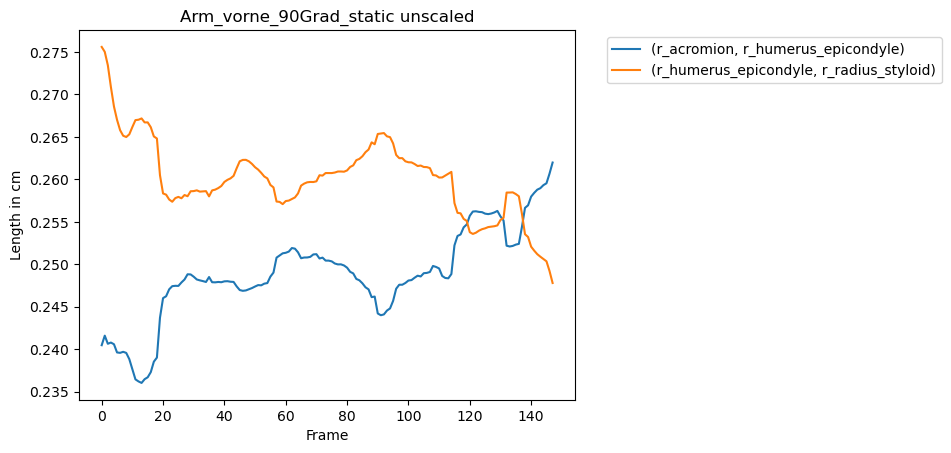

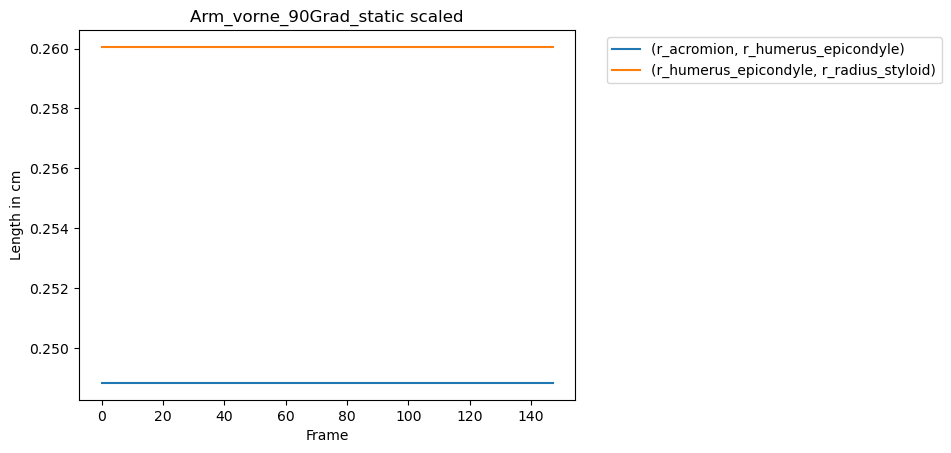

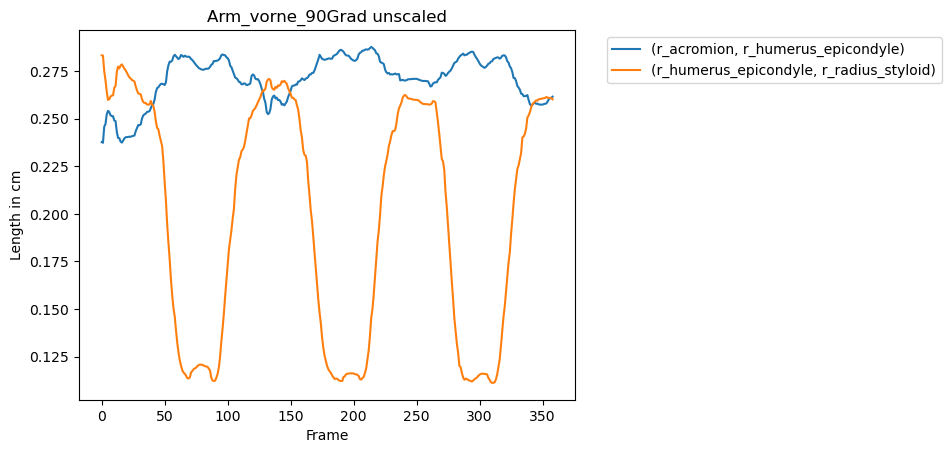

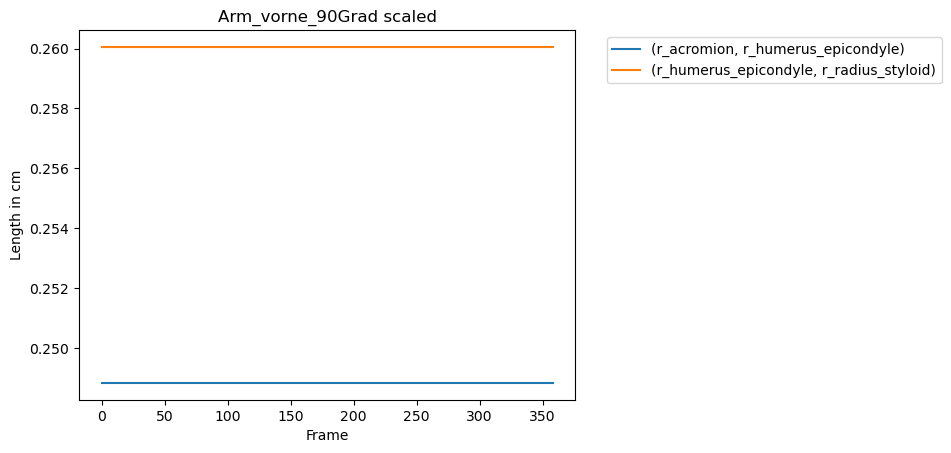

In [22]:
%%time
static_scaled, video_scaled = scale(static_name, video_name, marker_names, limbs, anchor_marker, anchor_vector, plots=True)

In [23]:
%%time
# to_trc(static_name)
# to_trc(video_name)

to_trc(static_scaled)
to_trc(video_scaled)

Converting to .trc file...
✅ TRC-Datei erfolgreich erstellt: output/Arm_vorne_90Grad_static_scaled.trc
Converting to .trc file...
✅ TRC-Datei erfolgreich erstellt: output/Arm_vorne_90Grad_scaled.trc
CPU times: total: 31.2 ms
Wall time: 34.6 ms


---